In [18]:
PROJECT_ID = "livescore-web" #@param {type:"string"}
! gcloud config set project $PROJECT_ID

Updated property [core/project].


In [8]:
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

# If you are running this notebook locally, replace the string below with the
# path to your service account key and run this cell to authenticate your GCP
# account.
else:
  %env GOOGLE_APPLICATION_CREDENTIALS '~/.config/gcloud/application_default_credentials.json'

env: GOOGLE_APPLICATION_CREDENTIALS='~/.config/gcloud/application_default_credentials.json'


In [0]:
BUCKET_NAME = "cost_anomaly_detection" #@param {type:"string"}
REGION = "europe-west1" #@param {type:"string"}

In [20]:
! gsutil ls -al gs://$BUCKET_NAME

                                 gs://cost_anomaly_detection/anomaly_lstm_20200520_130156/
                                 gs://cost_anomaly_detection/prediction_routine/
                                 gs://cost_anomaly_detection/preproc/


In [0]:
# %%writefile trainer_custom/preprocess.py

import numpy as np
import tensorflow as tf


# Define Global Parameters
feature_columns = ["cost", "noCost"]
label_column = "cost"
batch_size = 5
sequence_length = 7
num_features = len(feature_columns)

class Encoder_Preprocessor(object):
    
    def __init__(self, bucket_name, columns, sequence_length, batch_size, feature_columns, label_column, scaling_method):
        
        self._bucket_name = bucket_name
        self._scaler_parameter = {name: None for name in columns}
        self._scaling_method = scaling_method
        self._sequence_length = sequence_length
        self._batch_size = batch_size
        self._feature_columns = feature_columns
        self._label_column = label_column
        self._train_size = None
        self._test_size = None
    
    def read_data_csv(self, filepath_remote, data_mode = "train", header_included = True):
        
        import csv
        from google.cloud import storage
      
        storage_client = storage.Client()
        bucket = storage_client.bucket(self._bucket_name)
        if data_mode == "train":
            filepath = "{}/train.csv".format(filepath_remote)
            filepath_local = "train.csv"
        else:
            filepath = "{}/test.csv".format(filepath_remote)
            filepath_local = "test.csv"
        blob = bucket.blob(filepath)
        blob.download_to_filename(filepath_local)
    
        data_dict = {}
        with open(filepath_local, newline = "") as csvfile:
            data = list(csv.reader(csvfile))
        header = data[0]
        data = np.array(data[1:], dtype = np.float32) if header_included else np.array(data, dtype = np.float32)
        for index, name in enumerate(header):
            data_dict[name] = data[:, index]

        return data_dict
        
    def get_sequence(self, data):
        
        sequence = []
        num_elements = data.shape[0]
        
        for start, end in zip(range(0, num_elements-self._sequence_length), range(self._sequence_length, num_elements)):
            sequence.append(data[start:end])
        sequence = np.asarray(sequence).reshape((num_elements-self._sequence_length, self._sequence_length, 1))
        
        return sequence
    
    def scaling_process(self, data, key):

        if self._scaling_method == "MinMax":
            if self._scaler_parameter[key] is None:
                self._scaler_parameter[key] = [np.min(data), np.max(data)]
        
            data = np.divide(
                np.subtract(data, self._scaler_parameter[key][0]), 
                np.subtract(self._scaler_parameter[key][1], self._scaler_parameter[key][0])
            )

        elif self._scaling_method == "Standardized":
            if self._scaler_parameter[key] is None:
                self._scaler_parameter[key] = [np.mean(data), np.std(data)]
            
            data = np.divide(
                np.subtract(data, self._scaler_parameter[key][0]),
                self._scaler_parameter[key][1]
            )
        
        elif self._scaling_method == "Origin":
            data = data
        
        else:
            raise ValueError("Scaling Method Should be One of MinMax, Standardized and Origin")
        
        return data
    
    def inverse_scaling_process(self, data, key):
        
        if self._scaling_method == "MinMax":
            data = np.multiply(data, np.substract(self._scaler_parameter[key][1], self._scaler_parameter[key][0]))
            data = np.add(data, self._scaler_parameter[key][0])
          
        elif self._scaling_method == "Standardized":
            data = np.multiply(data, self._scaler_parameter[key][1])
            data = np.add(data, self._scaler_parameter[key][0])
        
        elif self._scaling_method == "Origin":
            data = data

        else:
            raise ValueError("Scaling Method Should be One of MinMax, Standardized and Origin")

        return data
    
    def tensorflow_transform_for_encoder(self, feature, label, data_mode = "train"):
    
        dataset = tf.data.Dataset.from_tensor_slices((feature, label))
        if data_mode == "train":
            dataset = dataset.cache().shuffle(self._train_size).batch(self._batch_size).repeat()
        else:
            dataset = dataset.cache().batch(self._batch_size)
        
        tensor_predict = feature
    
        return dataset, tensor_predict
    
    def preprocess_encoder(self, filepath_remote):
        
        feature_train = []
        feature_test = []
        data_train_dict = self.read_data_csv(filepath_remote, data_mode = "train")
        data_test_dict = self.read_data_csv(filepath_remote, data_mode = "test")
        
        for key in self._feature_columns:
            data_train = data_train_dict[key]
            data_train = self.min_max_process(data_train, key)
            data_train = self.get_sequence(data_train)
            self._train_size = data_train.shape[0]
            feature_train.append(data_train)
        
            data_test = data_test_dict[key]
            data_test = self.min_max_process(data_test, key)
            data_test = self.get_sequence(data_test)
            self._test_size = data_test.shape[0]
            feature_test.append(data_test)
        
        feature_train = tf.concat([feature_train[_] for _ in range(len(feature_train))], axis = 2)
        feature_test = tf.concat([feature_test[_] for _ in range(len(feature_test))], axis = 2)
    
        dataset_train, tensor_to_extract = self.tensorflow_transform_for_encoder(feature_train, feature_train, data_mode = "train")
        dataset_test, tensor_to_eval = self.tensorflow_transform_for_encoder(feature_test, feature_test, data_mode = "test")
        
        return dataset_train, tensor_to_extract, dataset_test, tensor_to_eval
    


class Forecaster_Preprocessor(Encoder_Preprocessor):
    
    def __init__(self, bucket_name, columns, sequence_length, batch_size, feature_columns, label_column, extract_mode):
        
        super().__init__(bucket_name, columns, sequence_length, batch_size, feature_columns, label_column)
        self._extract_mode = extract_mode

        
    def get_label(self, data):

        if type(data) == type({}):
            data = data[self._label_column]
        else:
            data = data

        num_elements = data.shape[0]
        label = np.asarray(data[self._sequence_length:num_elements])
        label = label.reshape((data[self._sequence_length:num_elements].shape[0], 1))

        return label
    
    # Create a function to extract features from LSTM encoder and prepare them for LSTM forecaster
    def ensemble_averaging(self, feature):
    
        feature_extract = np.array(
            [tf.math.reduce_mean(feature[x, y, :]) for x in range(feature.shape[0]) for y in range(feature.shape[1])]
        )
        feature_extract = tf.convert_to_tensor(feature_extract.reshape((feature.shape[0], feature.shape[1], 1)))
    
        return feature_extract
    
    def sequence_extraction(self, encoder, feature):
    
        feature_encoded = encoder.predict(feature)
        feature_ensemble = self.ensemble_averaging(feature)
    
        # Encoder will generate multiple sequences from original one.
        # We can directly use the raw sequences generated from encoder Or use the ensembled sequence (averaging).
        # We can also consider whether includes fixtures in the forecaster.
        if self._extract_mode == "raw":
            feature_extract = tf.concat([feature_encoded, feature], axis = 2)     
        else:
            feature_extract = tf.concat([feature_ensemble, feature], axis = 2)       
    
        return feature_extract

    def preprocess_forecaster(self, encoder, filepath_remote):
        
        _, feature_train, _, feature_test = self.preprocess_encoder(filepath_remote)
        feature_extract = self.sequence_extraction(encoder, feature_train)
        feature_eval = self.sequence_extraction(encoder, feature_test)
        
        data_train_dict = self.read_data_csv(filepath_remote, data_mode = "train")
        data_train = data_train_dict[self._label_column]
        data_train = self.min_max_process(data_train, self._label_column)
        label_train = tf.convert_to_tensor(self.get_label(data_train))

        data_test_dict = self.read_data_csv(filepath_remote, data_mode = "test")
        data_test = data_test_dict[self._label_column]
        data_test = self.min_max_process(data_test, self._label_column)
        label_test = tf.convert_to_tensor(self.get_label(data_test))
        
        dataset_train, _ = self.tensorflow_transform_for_encoder(feature_extract, label_train, data_mode = "train")
        dataset_test, _ = self.tensorflow_transform_for_encoder(feature_eval, label_test, data_mode = "test")
    
        return dataset_train, dataset_test, feature_extract, feature_eval, label_train, label_test

In [144]:
! gsutil cp train.csv test.csv gs://cost_anomaly_detection/preproc/

Copying file://train.csv [Content-Type=text/csv]...
Copying file://test.csv [Content-Type=text/csv]...
/ [2 files][  6.0 KiB/  6.0 KiB]                                                
Operation completed over 2 objects/6.0 KiB.                                      


In [2]:
import pickle

encoder_preprocessor = Encoder_Preprocessor("cost_anomaly_detection", feature_columns, sequence_length, batch_size, feature_columns, label_column)
dataset_train, _, dataset_test, _ = encoder_preprocessor.preprocess_encoder(filepath_remote = "preproc")

# with open ("encoder_preprocessor.pkl", "wb") as f:
    # pickle.dump(encoder_preprocessor, f)

/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not

In [0]:
# %%writefile trainer_custom/model.py

import shutil, os, datetime
import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

from trainer_custom import preprocess


# Define some hyperparamters
feature_columns = preprocess.feature_columns
num_features = len(feature_columns)
label_column = preprocess.label_column

batch_size = 5
sequence_length = 7
epochs_encoder = 100
epochs_forecaster = 50
extract_mode = "raw"
dropout = 0.3
encode_wide = [128]
decode_wide = [32]
forecaster_wide = [400, 200]
dense_size = 200
evaluation_interval = 200
num_extracts = num_features + encode_wide[0] if extract_mode == "raw" else num_features + 1

# with open("encoder_preprocessor.pkl", "rb") as f:
    # encoder_preprocessor = pickle.load(f)

validation_steps = int(encoder_preprocessor._test_size / batch_size)



class LSTM_Autoencoder(object):
    
    def __init__(self, sequence_length, num_features, dropout, encode_wide, decode_wide, 
                 epochs_encoder, validation_steps, evaluation_interval):
        
        self._sequence_length = sequence_length
        self._num_features = num_features
        self._dropout = dropout
        self._encode_wide = encode_wide
        self._decode_wide = decode_wide
        self._epochs_encoder = epochs_encoder
        self._validation_steps = validation_steps
        self._evaluation_interval = evaluation_interval
           
    # Create a function for build a LSTM Autoencoder
    def build_autoencoder(self):
    
        # Neuron Architecture
        # Input Layer
        input_layer = Input(shape = (self._sequence_length, self._num_features))
        # Encoder Layer
        for deep, wide in enumerate(self._encode_wide):
            if deep == 0:
                encoded_layer = LSTM(wide, return_sequences = True)(input_layer, training = True)
                # encoded_layer = BatchNormalization()(encoded_layer, training = True)
                encoded_layer = Dropout(self._dropout)(encoded_layer, training = True)       
            else:
                encoded_layer = LSTM(wide, return_sequences = True)(encoded_layer, training = True)
                # encoded_layer = BatchNormalization()(encoded_layer, training = True)
                encoded_layer = Dropout(self._dropout)(encoded_layer, training = True)
        # Decoder Layer
        for deep, wide in enumerate(self._decode_wide):
            if deep == 0:
                decoded_layer = LSTM(wide, return_sequences = True)(encoded_layer, training = True)
                # decoded_layer = BatchNormalization()(decoded_layer, training = True)
                decoded_layer = Dropout(self._dropout)(decoded_layer, training = True)
            else:
                decoded_layer = LSTM(wide, return_sequences = True)(decoded_layer, training = True)
                # decoded_layer = BatchNormalization()(decoded_layer, training = True)
                decoded_layer = Dropout(self._dropout)(decoded_layer, training = True)
        # Output Layer
        output_layer = TimeDistributed(Dense(self._num_features))(decoded_layer)
    
        lstm_encoder = Model(input_layer, encoded_layer)
        lstm_autoencoder = Model(input_layer, output_layer)
        lstm_autoencoder.compile(optimizer = RMSprop(), loss = "mean_squared_error", metrics = ["mae", "mape"])
    
        return lstm_encoder, lstm_autoencoder

    def train_autoencoder(self, dataset_train, dataset_test, output_dir):

        lstm_encoder, lstm_autoencoder = self.build_autoencoder()
        print("Here is our LSTM-Autoencoder architecture so far:\n")
        lstm_autoencoder.summary()
        print("\n")
    
        log_path = os.path.join(output_dir, "logs_autoencoder")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path)
        history = lstm_autoencoder.fit(
            dataset_train, epochs = self._epochs_encoder, steps_per_epoch = self._evaluation_interval, 
            validation_data = dataset_test, validation_steps = self._validation_steps, verbose = 2, 
            callbacks = [tensorboard_callback]
        )
    
        export_path = os.path.join(output_dir, "lstm_encoder", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tf.saved_model.save(lstm_encoder, export_path)
        lstm_encoder.save("{}/encoder.h5".format(export_path))
        print("\nSaved LSTM-Encoder to {}".format(export_path))
    
        return lstm_encoder, history
    
    
    
class LSTM_Forecaster(object):
    
    def __init__(self, dropout, sequence_length, evaluation_interval, validation_steps, num_extracts, forecaster_wide, dense_size, epochs_forecaster):
        
        self._dropout = dropout
        self._sequence_length = sequence_length
        self._evaluation_interval = evaluation_interval
        self._validation_steps = validation_steps
        self._num_extracts = num_extracts
        self._forecaster_wide = forecaster_wide
        self._dense_size = dense_size
        self._epochs_forecaster = epochs_forecaster
        
    # Create a function to build LSTM forecaster
    def rmse(self, y, y_pred):
        return tf.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y))) 

    def build_forecaster(self):
    
        ### Neuron Architecture
        # Input Layer
        input_lstm = Input(shape = (self._sequence_length, self._num_extracts))
        # LSTM Layer
        if len(self._forecaster_wide) == 1:
            lstm = LSTM(self._forecaster_wide[0], return_sequences = False)(input_lstm, training = True)
            # lstm = BatchNormalization()(lstm, training = True)
            lstm = Dropout(self._dropout)(lstm, training = True)
        else:
            for deep, wide in enumerate(self._forecaster_wide):
                if deep == 0:
                    lstm = LSTM(wide, return_sequences = True)(input_lstm, training = True)
                    # lstm = BatchNormalization()(lstm, training = True)
                    lstm = Dropout(self._dropout)(lstm, training = True)
                elif deep == len(self._forecaster_wide) - 1:
                    lstm = LSTM(wide, return_sequences = False)(lstm, training = True)
                    # lstm = BatchNormalization()(lstm, training = True)
                    lstm = Dropout(self._dropout)(lstm, training = True)
                else:
                    lstm = LSTM(wide, return_sequences = True)(lstm, training = True)
                    # lstm = BatchNormalization()(lstm, training = True)
                    lstm = Dropout(self._dropout)(lstm, training = True)
        # Output Layer
        dense = Dense(self._dense_size)(lstm)
        output_lstm = Dense(1)(dense)
    
        forecaster = Model(input_lstm, output_lstm)
        forecaster.compile(optimizer = RMSprop(), loss = "mean_squared_error", metrics = ["mae", "mape"])
    
        return forecaster

    def train_forecaster(self, dataset_train, dataset_test, output_dir):
    
        lstm_forecaster = self.build_forecaster()
        print("Here is our LSTM-Forecaster architecture so far:\n")
        lstm_forecaster.summary()
        print("\n")
    
        log_path = os.path.join(output_dir, "logs_forecaster", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_path)
        history = lstm_forecaster.fit(
            dataset_train, epochs = self._epochs_forecaster, steps_per_epoch = self._evaluation_interval, 
            validation_data = dataset_test, verbose = 2, validation_steps = self._validation_steps,
            callbacks = [tensorboard_callback]
        )
        export_path = os.path.join(output_dir, "lstm_forecaster", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tf.saved_model.save(lstm_forecaster, export_path)
        lstm_forecaster.save("{}/forecaster.h5".format(export_path))
        print("\nSaved LSTM-Forecaster to {}".format(export_path))

        return lstm_forecaster, history

In [6]:
# from trainer_custom.model import LSTM_Autoencoder

model = LSTM_Autoencoder(
    sequence_length = 7, num_features = 2, dropout = 0.3, encode_wide = [128], decode_wide = [32],
    epochs_encoder = 100, validation_steps = 8, evaluation_interval = 200
)
encoder, history_encoder = model.train_autoencoder(dataset_train, dataset_test, "./local_output")

Here is our LSTM-Autoencoder architecture so far:

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 2)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 128)            67072     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 32)             20608     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 2)              66        
Total params: 87,746
Trainable params: 87,746
Non-trainable params: 0
____

In [12]:
# from trainer_custom.preprocess import Forecaster_Preprocessor
import pickle

forecaster_preprocessor = Forecaster_Preprocessor(
    bucket_name = "cost_anomaly_detection", columns = ["cost", "noCost"], sequence_length = 7,
    extract_mode = "raw", label_column = "cost", batch_size = 5, feature_columns = ["cost", "noCost"]
)
dataset_train, dataset_test, tensor_to_eval, tensor_to_predict, label_train, label_test = forecaster_preprocessor.preprocess_forecaster(encoder, "preproc")

# with open ("forecaster_preprocessor.pkl", "wb") as f:
    # pickle.dump(forecaster_preprocessor, f)

/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not

In [10]:
# from trainer_custom.model import LSTM_Forecaster

lstm_forecaster = LSTM_Forecaster(
    dropout = 0.3, sequence_length = 7,
    num_extracts = 130, forecaster_wide = [400, 200], dense_size = 200,
    epochs_forecaster = 50, validation_steps = 8, evaluation_interval = 200
)
lstm_forecaster, history_forecaster = lstm_forecaster.train_forecaster(dataset_train, dataset_test, output_dir = "./local_output")

Here is our LSTM-Forecaster architecture so far:

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 130)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 400)            849600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 400)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_2 (

In [0]:
forecasts = lstm_forecaster.predict(tensor_to_eval)
pred = lstm_forecaster.predict(tensor_to_predict)

In [0]:
label_train = label_train * (encoder_preprocessor._scaler_parameter["cost"][1] - encoder_preprocessor._scaler_parameter["cost"][0]) + encoder_preprocessor._scaler_parameter["cost"][0]
forecasts = forecasts * (encoder_preprocessor._scaler_parameter["cost"][1] - encoder_preprocessor._scaler_parameter["cost"][0]) + encoder_preprocessor._scaler_parameter["cost"][0]

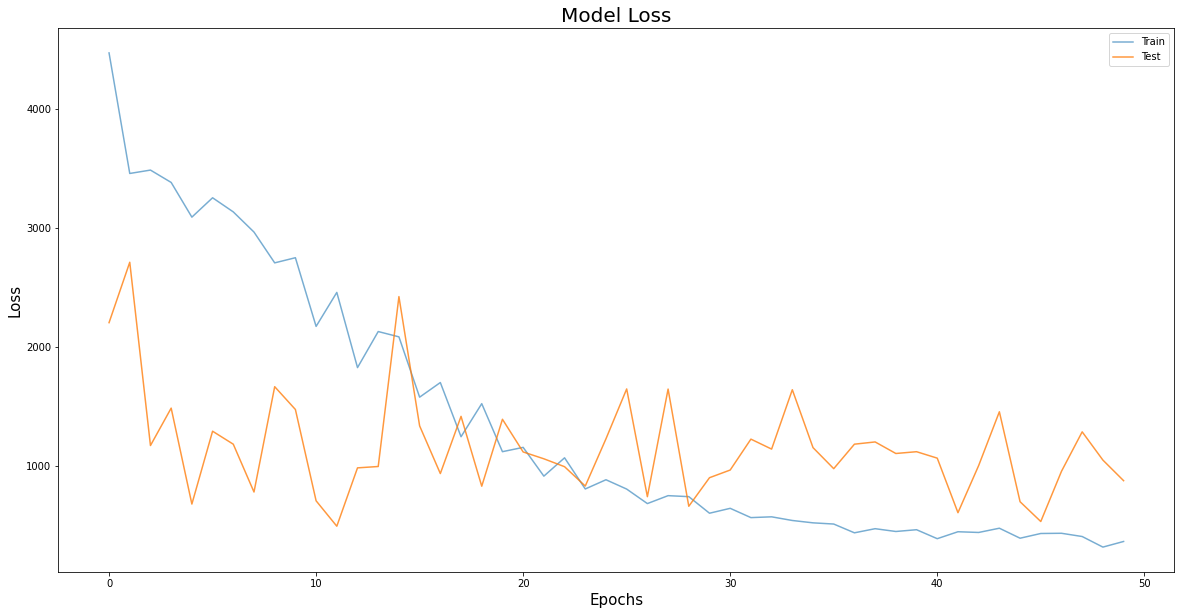

In [201]:
import matplotlib.pyplot as plt

def loss_plot(history):
    
    plt.figure(figsize = (20, 10))
    plt.plot(history.history["loss"], alpha = 0.6)
    plt.plot(history.history["val_loss"], alpha = 0.8)
    plt.title("Model Loss", fontsize = 20)
    plt.xlabel("Epochs", fontsize = 15)
    plt.ylabel("Loss", fontsize = 15)
    plt.legend(["Train", "Test"], loc = "upper right")
    plt.show()
    
loss_plot(history_forecaster)

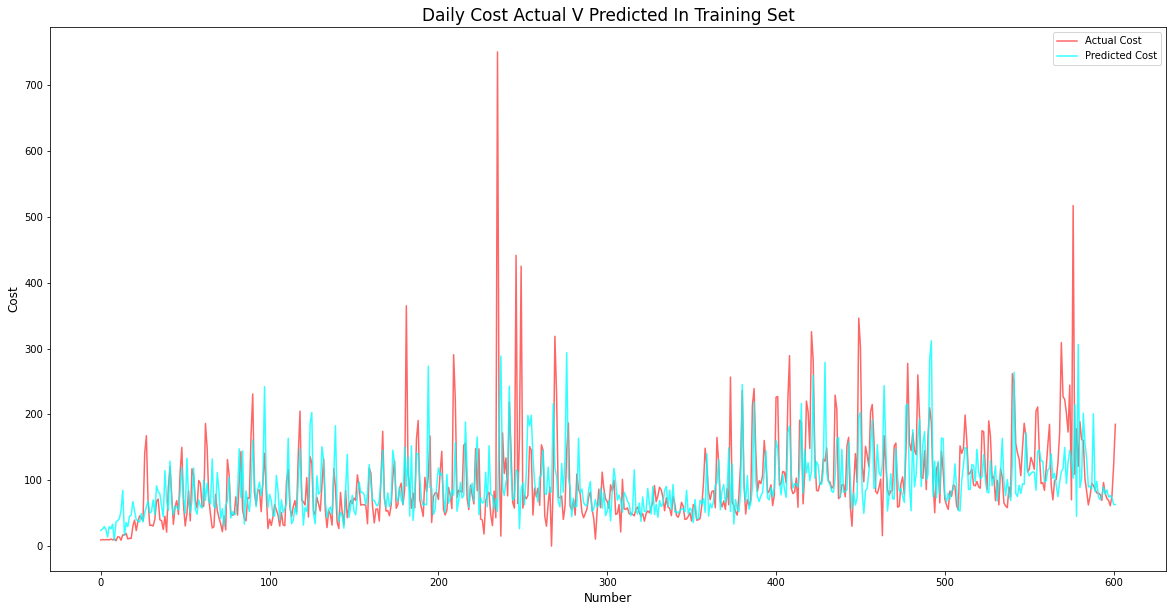

In [20]:
def actual_v_prediction_plot(forecasts, actuals, mode = "Training"):

    import matplotlib.pyplot as plt
    
    plt.figure(figsize = (20, 10))
    plt.plot(actuals, alpha = 0.6, c = "red")
    plt.plot(forecasts, alpha = 0.8, c = "cyan")
    plt.title("Daily Cost Actual V Predicted" + " In " + mode + " Set", fontsize = 17)
    plt.ylabel("Cost", fontsize = 12)
    plt.xlabel("Number", fontsize = 12)
    plt.legend(["Actual Cost", "Predicted Cost", "Outlier"], loc = "upper right")
    plt.show()
    
    
actual_v_prediction_plot(forecasts, label_train)

In [3]:
import tensorflow as tf
from trainer_custom.model import LSTM_Forecaster

encoder = tf.keras.models.load_model(
  "/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/local_output/lstm_encoder/20200520-220513"
)
encoder.summary()

forecaster = tf.keras.models.load_model(
  "forecaster.h5"
)
forecaster.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 2)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 128)            67072     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
Total params: 67,072
Trainable params: 67,072
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 130)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 7, 400)            849600    
__________________________________________

In [26]:
%%writefile trainer_custom/predictor.py

import os, pickle, datetime

import numpy as np
import tensorflow as tf

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *

class ModelPredictor(object):
    
    def __init__(self, encoder, forecaster, encoder_preprocessor, forecaster_preprocessor):
        
        self._encoder = encoder
        self._forecaster = forecaster
        self._encoder_preprocessor = encoder_preprocessor
        self._forecaster_preprocessor = forecaster_preprocessor
    
    def predict(self, encoder, filepath):
        
        # As default train_split = 595 is greater than our prediction data, so all prediction data would be treated as tensor_to_extract
        _, tensor_to_extract, _, _ = self._encoder_preprocessor.preprocess_encoder(
            filepath
        )
        feature_extract = self._encoder.predict(tensor_to_extract)
        _, _, feature_extract, _ = self._forecaster_preprocessor.preprocess_forecaster(
            encoder, filepath
        )
        outputs = self._forecaster.predict(feature_extract)
        
        return outputs

    @classmethod
    def encoder_from_path(cls, model_dir):
        
        encoder_path = os.path.join(model_dir, "encoder.h5")
        encoder = tf.keras.models.load_model(encoder_path)
        
        encoder_preprocessor_path = os.path.join(model_dir, "encoder_preprocessor.pkl")
        with open(encoder_preprocessor_path, "rb") as f:
            encoder_preprocessor = pickle.load(f)
            
        return cls(encoder, encoder_preprocessor)
    
    def forecaster_from_path(cls, model_dir):
        
        forecaster_path = os.path.join(model_dir, "forecaster.h5")
        forecaster = tf.keras.models.load_model(forecaster_path)
        
        forecaster_preprocessor_path = os.path.join(model_dir, "forecaster_preprocessor.pkl")
        with open(forecaster_preprocessor_path, "rb") as f:
            forecaster_preprocessor = pickle.load(f)
        
        return cls(forecaster, forecaster_preprocessor)

Overwriting trainer_custom/predictor.py


In [0]:
with open("encoder_preprocessor.pkl", "rb") as f:
    encoder_preprocessor = pickle.load(f)

with open("forecaster_preprocessor.pkl", "rb") as f:
    forecaster_preprocessor = pickle.load(f)

In [0]:
from trainer_custom.predictor import ModelPredictor

predictor = ModelPredictor(encoder, forecaster, encoder_preprocessor, forecaster_preprocessor)
pred = predictor.predict(encoder, "cost_null_project.csv")

In [11]:
%%writefile trainer_custom/setup.py
from setuptools import setup

setup(
    name = "lstm_anomaly_detector",
    version = "0.1",
    scripts = ["predictor.py", "preprocess.py"]
)

Overwriting trainer_custom/setup.py


In [12]:
! python trainer_custom/setup.py sdist --formats=gztar

running sdist
running egg_info
writing lstm_anomaly_detector.egg-info/PKG-INFO
writing dependency_links to lstm_anomaly_detector.egg-info/dependency_links.txt
writing top-level names to lstm_anomaly_detector.egg-info/top_level.txt
reading manifest file 'lstm_anomaly_detector.egg-info/SOURCES.txt'
writing manifest file 'lstm_anomaly_detector.egg-info/SOURCES.txt'

running check


creating lstm_anomaly_detector-0.1
creating lstm_anomaly_detector-0.1/lstm_anomaly_detector.egg-info
copying files to lstm_anomaly_detector-0.1...
copying lstm_anomaly_detector.egg-info/PKG-INFO -> lstm_anomaly_detector-0.1/lstm_anomaly_detector.egg-info
copying lstm_anomaly_detector.egg-info/SOURCES.txt -> lstm_anomaly_detector-0.1/lstm_anomaly_detector.egg-info
copying lstm_anomaly_detector.egg-info/dependency_links.txt -> lstm_anomaly_detector-0.1/lstm_anomaly_detector.egg-info
copying lstm_anomaly_detector.egg-info/top_level.txt -> lstm_anomaly_detector-0.1/lstm_anomaly_detector.egg-info
Writing lstm_anomal

In [38]:
! gsutil cp ./dist/lstm_anomaly_detector-0.1.tar.gz gs://$BUCKET_NAME/prediction_routine/lstm_anomaly_detector-0.1.tar.gz
! gsutil cp encoder.h5 forecaster.h5 encoder_preprocessor.pkl forecaster_preprocessor.pkl gs://$BUCKET_NAME/prediction_routine/model/

Copying file://./dist/lstm_anomaly_detector-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  547.0 B/  547.0 B]                                                
Operation completed over 1 objects/547.0 B.                                      
Copying file://encoder.h5 [Content-Type=application/octet-stream]...
Copying file://forecaster.h5 [Content-Type=application/octet-stream]...
Copying file://encoder_preprocessor.pkl [Content-Type=application/octet-stream]...
Copying file://forecaster_preprocessor.pkl [Content-Type=application/octet-stream]...
\ [4 files][ 10.8 MiB/ 10.8 MiB]                                                
Operation completed over 4 objects/10.8 MiB.                                     


In [0]:
MODEL_NAME = "LSTMPredictor"
VERSION_NAME = "v1"

In [46]:
! gcloud ai-platform models create $MODEL_NAME \
  --regions $REGION \

Created ml engine model [projects/livescore-web/models/LSTMPredictor].


In [0]:
# --quiet automatically installs the beta component if it isn't already installed 
! gcloud --quiet beta ai-platform versions create $VERSION_NAME \
  --model $MODEL_NAME \
  --runtime-version 1.13 \
  --python-version 3.5 \
  --origin gs://$BUCKET_NAME/prediction_routine/model/ \
  --package-uris gs://$BUCKET_NAME/prediction_routine/lstm_anomaly_detector-0.1.tar.gz \
  --prediction-class predictor.ModelPredictor

In [0]:
class AnomalyPredictor(object):

    def __init__(self, project, bucket_name, filepath_remote, filepath_local, encoder, forecaster, sequence_length, num_extracts):

        self._project = project
        self._bucket_name = bucket_name
        self._filepath_remote = filepath_remote
        self._filepath_local = filepath_local
        self._encoder = encoder
        self._forecaster = forecaster
        self._sequence_length = sequence_length
        self._num_extracts = num_extracts

    ### Directly read input data from Google Cloud Storage
    def read_data_bucket(self, header_included = True):

        import csv
        import numpy as np
        from google.cloud import storage

        client = storage.Client()
        bucket = client.get_bucket(self._bucket_name)
        blob = bucket.get_blob(self._filepath_remote)
        blob.download_to_filename(self._filepath_local)

        with open(self._filepath_local, newline = "") as csvfile:
            data = list(csv.reader(csvfile))
            header = data[0]
            data = np.array(data[1:], dtype = np.float32) if header_included else np.array(data, dtype = np.float32)

        return data
    ### Directly read input data via BigQuery (Client)
    def read_data_bigquery(self):
        
        from google.cloud import bigquery

        client = bigquery.Client()
        query_job = client.query("""
            SELECT
              cost,
              noCost
            FROM (
            SELECT 
              DATE(export_time) as date,
              IFNULL(project.id, "Null") AS project,
              ROUND(SUM(Cost), 2) AS cost,
              COUNT(Cost) AS noCost
            FROM
              `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
            WHERE
              project.id is null
            AND
              DATE(export_time) >= "2020-05-22"
            AND
              DATE(export_time) <= "2020-05-28"
            GROUP BY 
              date, project
            ORDER BY 
              date ASC
            )
        """)
        results = query_job.result().to_dataframe().values

        return results

    def reshape_data(self, data):

        num_features = data.shape[1]
        data = data.reshape((1, self._sequence_length, num_features)).tolist()

        return data

    def predict_json_encoder(self, instances, version = None):

        import googleapiclient.discovery

        service = googleapiclient.discovery.build("ml", "v1")
        name = "projects/{}/models/{}".format(self._project, self._encoder)

        if version is not None:
            name += "/versions/{}".format(version)

        response = service.projects().predict(
            name = name,
            body = {"instances": instances}
        ).execute()

        if "error" in response:
            raise RuntimeError(response["error"])

        return response["predictions"]

    def reshape_encoder_output(self, response, data):

        response = np.array(response[0]["dropout_2"]).reshape((1, self._sequence_length, self._num_extracts))
        response = np.concatenate([response, data], axis = 2).tolist()

        return response

    def predict_json_forecaster(self, instances, version = None):

        import googleapiclient.discovery

        service = googleapiclient.discovery.build("ml", "v1")
        name = "projects/{}/models/{}".format(self._project, self._forecaster)

        if version is not None:
            name += "/versions/{}".format(version)

        response = service.projects().predict(
            name = name,
            body = {"instances": instances}
        ).execute()

        if "error" in response:
            raise RuntimeError(response["error"])

        return response["predictions"]

    def predict_one_step(self):

        # data = self.read_data_bucket()
        data = self.read_data_bigquery()
        data = self.reshape_data(data)
        response = self.predict_json_encoder(data, version = "v1")
        response = self.reshape_encoder_output(response, data)
        output = self.predict_json_forecaster(response, version = "v1")

        return output

In [172]:
! gsutil cp prediction_input.csv gs://cost_anomaly_detection/preproc/

Copying file://prediction_input.csv [Content-Type=text/csv]...
/ [1 files][   72.0 B/   72.0 B]                                                
Operation completed over 1 objects/72.0 B.                                       


In [176]:
! gsutil ls gs://cost_anomaly_detection/preproc/

gs://cost_anomaly_detection/preproc/cost_null_project.csv
gs://cost_anomaly_detection/preproc/prediction_input.csv


In [0]:
predictor = AnomalyPredictor(
    bucket_name = "cost_anomaly_detection",
    project = "livescore-web",
    filepath_remote = "preproc/prediction_input.csv",
    filepath_local = "prediction_input.csv",
    encoder = "lstm_anomaly_cost",
    forecaster = "lstm_anomaly_cost_forecaster",
    sequence_length = 7,
    num_extracts = 128
)

In [52]:
output = predictor.predict_one_step()

/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/ziye.zhou/Documents/Work/cost_anomaly_detection/tensorflow-venv/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not

In [53]:
output

[{'dense_5': [36.81615447998047]}]

In [0]:
"2020-05-23" "35.7249"
"2020-05-24" "40.9180"
"2020-05-25" "23.6975"
"2020-05-26" "39.3539"
"2020-05-27" "40.1553"
"2020-05-28" "39.5835"
"2020-05-29" "36.8162"

In [0]:
from google.cloud import bigquery

client = bigquery.Client()
table_id = "livescore-web.testing.cost_output_prediction"

table = client.get_table(table_id)  # Make an API request.
rows_to_insert = [(u"date", "2020-05-28"), (u"predictedCost", output)]

errors = client.insert_rows(table, rows_to_insert)  # Make an API request.
if errors == []:
    print("New rows have been added.")

In [54]:
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
import uuid

credentials = GoogleCredentials.get_application_default()
service = build("bigquery", "v2", credentials = credentials)

body = {
    "rows": [
        {
            "json": {u"date": "2020-05-29", u"predictedCost": "36.8162"},
            "insertId": str(uuid.uuid4())   
        }
    ]
}
service.tabledata().insertAll(projectId = "livescore-web", datasetId = "testing", tableId = "cost_output_prediction", body = body).execute(num_retries = 3)

{'kind': 'bigquery#tableDataInsertAllResponse'}

In [0]:
from datetime import datetime, timedelta
from airflow import models
from airflow.contrib.operators.bigquery_operator import BigQueryOperator, BigQueryCreateEmptyTableOperator
from airflow.contrib.operators.bigquery_get_data import BigQueryGetDataOperator
from airflow.operators.python_operator import PythonOperator
from airflow.operators.dummy_operator import DummyOperator

project = "livescore-web"
encoder = "lstm_anomaly_cost"
forecaster = "lstm_anomaly_cost_forecaster"

### Default arguments for airflow DAGs
default_args = {
    "start_date": datetime(2020, 6, 01),
    "owner": "Ziye Zhou",
    "retries": 3,
    "retries_delay": timedelta(minutes = 5),
    "email": "data@livescore.com",
    "email_on_failure": True,
    "use_legacy_sql": False,
}

with models.DAG("get_daily_cost_prediction", default_args = default_args, schedule_interval = datetime.timedelta(days = 1)) as dag:

    input_sql = """
        SELECT
          cost,
          noCost
        FROM (
        SELECT 
          DATE(export_time) as date,
          IFNULL(project.id, "Null") AS project,
          ROUND(SUM(Cost), 2) AS cost,
          COUNT(Cost) AS noCost
        FROM
          `livescore-web.billing_export.gcp_billing_export_v1_011FA5_0CE22C_E40A99`
        WHERE
          project.id is null
        AND
          DATE(export_time) >= DATE_SUB(CURRENT_DATE, INTERVAL 7 DAY) 
        AND
          DATE(export_time) <= DATE_SUB(CURRENT_DATE, INTERVAL 1 DAY)
        GROUP BY 
          date, project
        ORDER BY 
          date ASC
        )
    """
    ### Create a BigQuery table to store input data
    create_input_bigquery_table = BigQueryCreateEmptyTableOperator(
        task_id = "create_bigquery_table",
        project_id = "livescore-web"
        dataset_id = "testing",
        table_id = "cost_prediction_input",
        schema_fields = [
            {"name": "cost", "type": "FLOAT", "mode": "REQUIRED"},
            {"name": "noCost", "type": "INTEGER", "mode": "REQUIRED"}
        ]
    )
    ### Create a BigQuery table to store output data (prediction)
    create_output_bigquery_table = BigQueryCreateEmptyTableOperator(
        task_id = "create_ouput_bigquery_table",
        project_id = "livescore-web",
        dataset_id = "testing",
        table_id = "cost_prediction_output",
        schema_fields = [
            {"name": "date", "type": "DATE", "mode": "REQUIRED"},
            {"name": "predictedCost", "type": "FLOAT", "mode": "REQUIRED"}
        ]
    )
    ### Get the results from input query and store them in the input table
    get_input_data = BigQueryOperator(
        task_id = "get_input_data",
        sql = input_sql,
        destination_dataset_table = "livescore-web:testing.cost_prediction_input",
    )
    ### Fetch data from a BigQuery table and return them as a Python list for next DAG's usage
    read_input_data = BigQueryGetDataOperator(
        task_id = "read_input_data",
        dataset_id = "testing",
        table_id = "cost_prediction_input"
    )
    ### Define callable functions to use for prediction
    def predict_json(instances, model, version = None):

        import googleapiclient.discovery

        service = googleapiclient.discovery.build("ml", "v1")
        name = "projects/{}/models/{}".format(project, model)

        if version is not None:
            name += "/versions/{}".format(version)

        response = service.projects().predict(
            name = name,
            body = {"instances": instances}
        ).execute()

        if "error" in response:
            raise RuntimeError(response["error"])

        return response["predictions"]
      
    def reshape_output(response, data):

        response = np.array(response[0]["dropout_2"]).reshape((1, sequence_length, num_extracts))
        response = np.concatenate([response, data], axis = 2).tolist()

        return response

    def get_prediction(** kwargs):

        ti = kwargs["ti"]
        input_data = ti.xcom_pull(task_ids = "read_input_data").tolist()
        response = predict_json(input_data, encoder, version = "v1")
        response = reshape_output(response, input_data)
        output = predict_json(response, forecaster, version = "v1")

        return output
    ### Get a prediction from input data
    get_prediction = PythonOperator(
        task_id = "get_prediction",
        python_callable = get_prediction
    )
    ### Not sure how to export data to a BigQuery table
    ### Pandas module can write dataframe object to a BigQuery table
    def write_bigquery(** kwargs):

        import pandas as pd

        ti = kwargs["ti"]
        output = ti.xcom_pull(task_ids = "get_prediction")
        output_df = pd.DataFrame({
            "date": datetime.today().strftime("%Y-%m-%d"),
            "predictedCost": output
        })
        table_id = "cost_prediction_output"
        output_df.to_gbq(table_id)   

    write_bigquery_table = PythonOperator(
        task_id = "write_bigquery_table",
        python_callable = write_bigquery
    )

    dag_complete = DummyOperator(
        task_id = "dag_complete"
    )

create_input_bigquery_table >> create_output_bigquery_table >> get_input_data >> read_input_data >> get_prediction >> write_bigquery_table

In [0]:
import uuid

def stream_data(credential, table, data, schema):
    # first checks if table already exists. If it doesn't, then create it
    r = service.tables().list(projectId = "livescore-web", datasetId = ).execute()
    table_exists = [row['tableReference']['tableId'] for row in
                    r['tables'] if
                    row['tableReference']['tableId'] == table]
    if not table_exists:
        body = {
            'tableReference': {
                'tableId': table,
                'projectId': your_project_id,
                'datasetId': your_dataset_id
            },
            'schema': schema
        }
        self.service.tables().insert(projectId=your_project_id,
                                     datasetId=your_dataset_id,
                                     body=body).execute()

    # with table created, now we can stream the data
    # to do so we'll use the tabledata().insertall() function.
    body = {
        'rows': [
            {
                'json': data,
                'insertId': str(uuid.uuid4())
            }
        ]
    }
    self.service.tabledata().insertAll(projectId=your_project_id),
                                       datasetId=your_dataset_id,
                                       tableId=table,
                                         body=body).execute(num_retries=5)